In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())

<br><br><br>

## Natural Language Processing
### :::: Word2Vec ::::

<br><br><br><br><br><br>





> For example Levy and Goldberg (2014a) showed that using skip-gram with awindow of±2, the most similar words to the wordHogwarts(from theHarry Potterseries) were names of other fictional schools:Sunnydale(fromBuffy the VampireSlayer) orEvernight(from a vampire series). With a window of±5, the most similarwords toHogwartswere other words topically related to theHarry Potterseries:Dumbledore,Malfoy, andhalf-blood


>  For example Bolukbasi et al. (2016) find that the closest occupationto ‘man’ - ‘computer programmer’ + ‘woman’ in word2vec embeddings trained onnews text is ‘homemaker’, and that the embeddings similarly suggest the analogy‘father’ is to ‘doctor’ as ‘mother’ is to ‘nurse’.  This could result in what Crawford(2017) and Blodgett et al. (2020) call anallocational harm, when a system allo-allocationalharmcates resources (jobs or credit) unfairly to different groups. Fo

> It turns out that embeddings don’t just reflect the statistics of their input,  butalsoamplifybias; gendered terms becomemoregendered in embedding space thanbiasamplificationthey were in the input text statistics (Zhao et al. 2017, Ethayarajh et al. 2019b, Jiaet al. 2020), and biases are more exaggerated than in actual labor employment statis-tics (Garg et al., 2018


## Word Vectors

Last week we sketched an idea of how to use neural nets to learn informative word representations:

<img src="figs/nn.png" width=70%/>

- Word vectors become hidden nodes in a neural network.
- An additional hidden layer allows non-linear transformations of word vectors
- Training the model to optimize $p(w_i \mid v_{i-1} \ldots v_{i-n})$ results in "useful" vectors for $v$.
- **Word representations are useful if they help us predict the next word in a sentence.**

There are a lot of scalability issues with this approach.

<br><br><br><br>
One trick: rather than predict a word, predict whether the two given words appear next to each other:

<img src="figs/nn2.png" width=80%/>

Below, we'll take a first pass at implementing this with sklearn using movie review data.

In [178]:
# read movie review data from https://www.cs.cornell.edu/people/pabo/movie-review-data/
import gzip
import re
def tokenize(sentence):
    return [t for t in sentence.split() if re.match('\w', t)]

sentences = [tokenize(line) for line in gzip.open('reviews.txt.gz', 'rt')]
print('%d sentences containing %d tokens. here is one:\n%s' % (len(sentences),
                                                               sum(len(s) for s in sentences),
                                                               sentences[500]))

64720 sentences containing 1291389 tokens. here is one:
['there', 'is', 'zero', 'humor', 'zero', 'suspense', 'zero', 'drama', 'and', 'zero', 'action', 'until', 'the', 'last', 'ten', 'minutes', 'when', 'the', 'story', 'is', 'needlessly', 'and', 'pointlessly', 'concluded', 'with', 'a', 'violent', 'sequence']


In [184]:
from collections import defaultdict, Counter

def make_vocabulary(sentences, min_count=5, max_count=5000):    
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update(sentence)
    words = [w for w,c in word_counts.items() if c >= min_count and c <= max_count]
    return {w:i for i,w in enumerate(words)}

min_count=50
max_count=5000
vocabulary = make_vocabulary(sentences, min_count, max_count)
print('%d unique words occuring at least %d times and not more than %d times' % 
      (len(vocabulary), min_count, max_count))

2518 unique words occuring at least 50 times and not more than 5000 times


In [185]:
from itertools import combinations
def get_word_cooccurrences(sentences, vocabulary):
    cooccurrences = np.zeros((len(vocabulary), len(vocabulary)))
    for sentence in sentences:
        words = [vocabulary[w] for w in sentence if w in vocabulary]
        for wi, wj in combinations(words, 2):
            if wi != wj:
                cooccurrences[wi][wj] += 1
                cooccurrences[wj][wi] += 1
    return pd.DataFrame(cooccurrences, columns=vocabulary.keys(), index=vocabulary.keys())

cooccurrences = get_word_cooccurrences(sentences, vocabulary)

In [186]:
cooccurrences

,plot,two,teen,go,church,party,then,drive,they,get,...,truman,nomination,jurassic,suspenseful,flynt,vampire,alex,mulan,outstanding,shrek
plot,0.0,48.0,2.0,24.0,2.0,7.0,43.0,9.0,80.0,60.0,...,2.0,0.0,3.0,3.0,0.0,2.0,0.0,0.0,2.0,0.0
two,48.0,0.0,7.0,49.0,3.0,10.0,52.0,3.0,216.0,66.0,...,3.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,2.0,0.0
teen,2.0,7.0,0.0,10.0,1.0,2.0,3.0,1.0,5.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
go,24.0,49.0,10.0,0.0,3.0,9.0,52.0,3.0,166.0,60.0,...,2.0,2.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,0.0
church,2.0,3.0,1.0,3.0,0.0,1.0,2.0,1.0,8.0,4.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vampire,2.0,3.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alex,0.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mulan,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
outstanding,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [192]:
cooccurrences['steven'].sort_values(ascending=False)

spielberg    21.0
seagal       19.0
at           15.0
from         14.0
director     14.0
             ... 
works         0.0
concept       0.0
terribly      0.0
killers       0.0
shrek         0.0
Name: steven, Length: 2518, dtype: float64

Now, let's make a binary classification task. Given two words, predict whether they cooccur or not. The only input is the  one hot encoding of each word.

There would be an awful lot of examples if we used every single instance. Instead, we'll pick randomly 10 positive and 10 negative for each word.

In [303]:
np.random.seed(42)

def multinomial(row, smoothing=10):
    return (row.values + smoothing) / (row.sum() + smoothing * len(row))

    
def sample_training_examples(cooccurrences, npos=5, nneg=5):
    vocab = cooccurrences.index
    result = []
    for word, row in cooccurrences.iterrows():
        # sample positives        
        probs = multinomial(row, smoothing=10)
        pos_sample = np.random.choice(vocab, size=npos, p=probs)
        result.extend({'w1': word, 'w2': pos, 'label': 1} for pos in pos_sample)
        # sample negatives
        neg_indices = np.where(row.values == 0)[0]
        neg_sample_idx = np.random.choice(neg_indices, size=nneg)
        result.extend({'w1': word, 'w2': vocab[n], 'label': -1}
                      for n in neg_sample_idx)
    return pd.DataFrame(result)
training_words = sample_training_examples(cooccurrences, npos=20, nneg=20)
training_words

,w1,w2,label
0,plot,sequence,1
1,plot,pleasure,1
2,plot,bizarre,1
3,plot,play,1
4,plot,away,1
...,...,...,...
100715,shrek,cold,-1
100716,shrek,imagination,-1
100717,shrek,fallen,-1
100718,shrek,form,-1


In [304]:
training_words = training_words.sample(frac=1, random_state=42)
training_words

,w1,w2,label
60111,hardly,contrast,-1
82559,explain,wondering,-1
19209,pure,don't,1
34080,product,deals,1
49187,comedic,thinks,-1
...,...,...,...
6265,sure,situation,-1
54886,york,outside,1
76820,catch,reminiscent,-1
860,what's,island,-1


In [307]:
training_words.groupby('w1')

**green**: $$[0,0,0,0,0,0,1,\ldots,0]$$

**eggs**: $$[1,0,0,0,0,0,0,\ldots,0]$$

**x**: $$[0,0,0,0,0,0,1,\ldots,0, ~~~~ 1,0,0,0,0,0,0,\ldots,0]$$

In [229]:
def vectorize(training_row, vocabulary):
    v1 = np.zeros(len(vocabulary))
    v2 = np.zeros(len(vocabulary))
    v1[vocabulary[training_row.w1]] = 1
    v2[vocabulary[training_row.w2]] = 1
    return np.concatenate((v1, v2))
    
vectorize(training_words.iloc[0], vocabulary)

array([0., 0., 0., ..., 0., 0., 0.])

In [309]:
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

def vectorize_batch(batch, vocabulary):
    X = []
    y = []
    for ri, row in batch.iterrows():
        X.append(vectorize(row, vocabulary))
        y.append(row['label'])
    return X, y
    
def train(training_words, vocabulary, batch_size=100, n_epochs=10):
    mlp = MLPClassifier(hidden_layer_sizes=[50, 10],
                        activation='relu',
                        solver='adam',
                        max_iter=1000,
                        random_state=1234)
    # reserve first 500 rows for unseen testing (e.g., accuracy on held-out data)
    X_test, y_test = vectorize_batch(training_words.iloc[:1000], vocabulary)    
    # use last 500 rows for in-sample testing (e.g., accuracy on training data)
    X_train, y_train = vectorize_batch(training_words.iloc[-1000:], vocabulary)    
    training_words = training_words.iloc[500:]
    for epoch in range(n_epochs):
        print('epoch %d' % epoch)
        # split into batches, to save memory.
        for _, batch in tqdm(training_words.groupby('w1')):
#         for batch in tqdm(np.array_split(training_words, len(training_words)//batch_size)):
            X, y = vectorize_batch(batch, vocabulary)
            for iteri in range(5):
                mlp.partial_fit(X, y, classes=[-1,1])
        print('train score=%.4f' % mlp.score(X_train, y_train))
        print('test score=%.4f' % mlp.score(X_test, y_test))
    return mlp

# mlp.fit(X, y)
# mlp.coefs_
mlp = train(training_words, vocabulary, batch_size=2000, n_epochs=1)

  0%|          | 3/2518 [00:00<01:38, 25.58it/s]

epoch 0


100%|██████████| 2518/2518 [01:28<00:00, 28.51it/s]


train score=0.5630
test score=0.5800


<img src="figs/nn3.png" width=80%/>

In [2]:
import torch
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

print(x_data.shape)
print(x_data.dtype)
print(x_data.device)

tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])
torch.int64
cpu


In [198]:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

torch.cat((tensor, tensor), dim=1)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


tensor([[1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.]])

In [199]:
tensor * tensor

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [200]:
tensor.add_(5)

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])

In [3]:
np.random.seed(42)
animals = ['aardvark', 'albatross', 'alligator', 'alpaca', 'anole', 'ant', 'anteater', 'antelope', 'ape', 'armadillo',
           'baboon', 'badger', 'barracuda', 'bat', 'bear', 'bee', 'bison', 'boar', 'bobcat', 'butterfly']
animal_vocab = {w: i for i,w in enumerate(animals)}
a_names = [a for a in animals if a[0] == 'a']
b_names = [b for b in animals if b[0] == 'b']
animal_data = pd.DataFrame(zip(np.random.choice(a_names, size=200), np.random.choice(a_names, size=200)),
                          columns=['w1', 'w2'])
animal_data = pd.concat((animal_data,
                       pd.DataFrame(zip(np.random.choice(b_names, size=200), np.random.choice(b_names, size=200)),
                          columns=['w1', 'w2'])))
animal_data = animal_data.sample(frac=1, random_state=42)
animal_data

,w1,w2
9,bear,boar
80,bat,badger
33,alligator,aardvark
10,bee,bear
93,armadillo,alligator
...,...,...
71,anole,antelope
106,alligator,alpaca
70,bison,barracuda
148,bear,barracuda


100%|██████████| 100/100 [00:01<00:00, 87.50it/s]


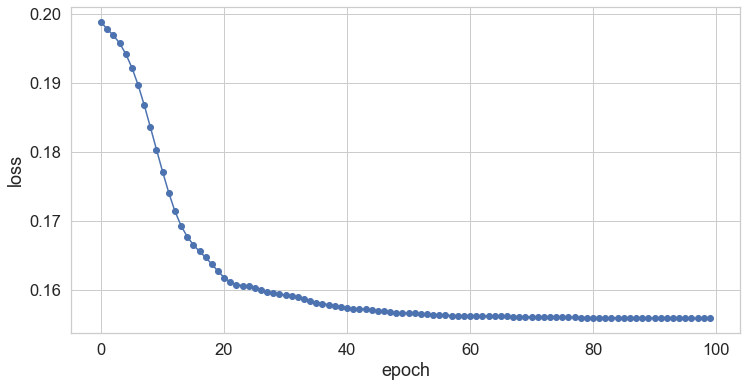

In [5]:
import torch.nn as nn
import math
from tqdm import tqdm

class WordPairModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(WordPairModel, self).__init__()
        self.verbose = verbose
        # linear == dense neural net layer
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        self.hidden = nn.Linear(embedding_size, vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        if self.verbose: print('x\n', x)
            
        embedding = self.embedding(x)
        if self.verbose: print('embedding\n', embedding)

        hidden = self.hidden(embedding)
        if self.verbose: print('hidden\n', hidden)

        output = self.softmax(hidden)
        if self.verbose: print('softmax\n', output)
        return output

def vectorize_torch(word, vocabulary):
    tensor = torch.zeros(1, len(vocabulary))
    tensor[0][vocabulary[word]] = 1.0
    return tensor

def make_word_pair_batch(rows, vocabulary):
    """
    return (input_tensor, output_tensor) tuple
    for all examples in rows.
    """
    return (torch.cat([vectorize_torch(w, vocabulary) for w in rows.w1]),
            torch.cat([vectorize_torch(w, vocabulary) for w in rows.w2]))
    
def output2label(output, words):
    # 0 if false is most probable prediction, 1 if true
    top_n, top_i = output.topk(1)
    return words[top_i.item()] # , math.exp(top_n)

def train_word_pair(data, vocab):
    torch.random.manual_seed(42)
    learning_rate = 0.1
    model = WordPairModel(len(vocab), embedding_size=2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

#     print(model)
#     # test model
#     output = model(vectorize_torch('aardvark', animal_vocab))
#     print('prediction', output2label(output, animals))

    model.verbose = False

    loss_val = []
    num_epochs=100
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        optimizer.zero_grad() # reset all the gradient information
        inputs, labels = make_word_pair_batch(data, vocab)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_val.append(loss.item())

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

word_pair_model = train_word_pair(animal_data, animal_vocab)

In [12]:
print(word_pair_model)

WordPairModel(
  (embedding): Linear(in_features=20, out_features=2, bias=False)
  (hidden): Linear(in_features=2, out_features=20, bias=False)
  (softmax): Softmax(dim=1)
)


In [10]:
def word2embedding(word, model, vocabulary):
    return model.embedding(vectorize_torch(word, vocabulary)).detach().cpu().numpy()[0]
word2embedding('ant', word_pair_model, animal_vocab)

array([-0.84147525, -0.6245872 ], dtype=float32)

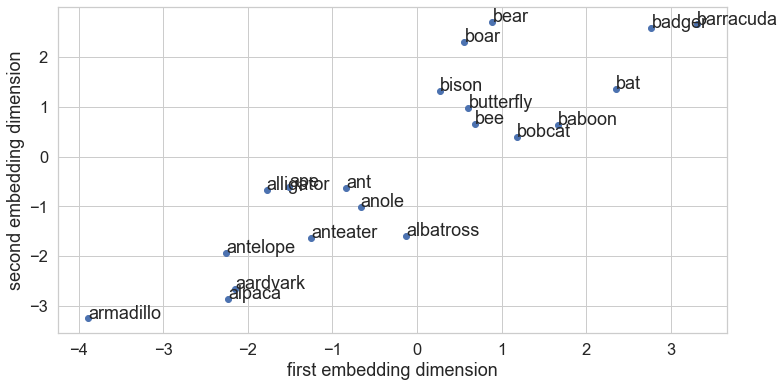

In [11]:
def plot_embeddings(animal_embeddings, animals):
    plt.figure()
    plt.scatter([e[0] for e in animal_embeddings],
                [e[1] for e in animal_embeddings])
    for animal, embed in zip(animals, animal_embeddings):
        plt.annotate(animal, (embed[0], embed[1]))
    plt.xlabel('first embedding dimension')
    plt.ylabel('second embedding dimension')
    plt.show()
    
animal_embeddings = [word2embedding(animal, word_pair_model, animal_vocab) for animal in animals]
plot_embeddings(animal_embeddings, animals)

In [540]:
# add negative examples
np.random.seed(42)
animal_data2 = animal_data.copy()
animal_data2 = pd.concat((animal_data2, pd.DataFrame(zip(np.random.choice(a_names, size=400), np.random.choice(b_names, size=400)),
                         columns=['w1', 'w2'])))
animal_data2 = pd.concat((animal_data2, pd.DataFrame(zip(np.random.choice(b_names, size=400), np.random.choice(a_names, size=400)),
                         columns=['w1', 'w2'])))
animal_data2['label'] = [1 if w1[0] == w2[0] else 0 for (w1, w2) in animal_data2.values]
animal_data2 = animal_data2.sample(frac=1, random_state=42)
animal_data2

,w1,w2,label
378,badger,ape,0
65,bee,anteater,0
110,aardvark,alligator,1
39,alpaca,boar,0
30,ape,alpaca,1
...,...,...,...
244,butterfly,armadillo,0
295,barracuda,anteater,0
330,bat,aardvark,0
60,badger,aardvark,0


In [626]:
def make_word2vec_batch(rows, vocabulary):
    """
    return (input_tensor, output_tensor) tuple
    for all examples in rows.
    """
    label_vocab = {0: 0, 1: 1}
    return (torch.cat([vectorize_torch(w, vocabulary) for w in rows.w1]),
            torch.cat([vectorize_torch(w, vocabulary) for w in rows.w2]),
            torch.tensor([float(l) for l in rows.label]))
make_word2vec_batch(animal_data2.iloc[:3], animal_vocab)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]),
 tensor([0., 0., 1.]))

In [634]:
# Next, let's try negative sampling to reduce model size.
# embed w1 and w2 separately, take their dot product, then predict binary classification.
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(Word2Vec, self).__init__()
        self.verbose = verbose
        self.input_embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        self.output_embedding = nn.Linear(vocab_size, embedding_size, bias=False)
#         self.embedding_to_output = nn.Bilinear(embedding_size, embedding_size, 2)
#         self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, w1, w2):
        if self.verbose: print('w1\n', w1, '\nw2\n', w2)            
        embedding1 = self.input_embedding(w1)
        embedding2 = self.input_embedding(w2)
        if self.verbose: print('embedding1\n', embedding1, '\nembedding2\n', embedding2)
#         combined = self.embedding_to_output(embedding1, embedding2)
#         if self.verbose: print('combined\n', combined)
        dotprod = torch.mul(embedding1, embedding2).squeeze()
        dotprod = torch.sum(dotprod, dim=1)
        if self.verbose: print('dotprod\n', dotprod)
        output = self.sigmoid(dotprod)
        if self.verbose: print('sigmoid\n', output)
#         output = self.softmax(combined)
#         if self.verbose: print('softmax\n', output)
        return output
torch.random.manual_seed(42)
w2v = Word2Vec(len(animal_vocab), 2, verbose=True)
print(w2v)
# test model
bb = make_word2vec_batch(animal_data2.iloc[:3], animal_vocab)
output = w2v(bb[0], bb[1])
print(output)

Word2Vec(
  (input_embedding): Linear(in_features=20, out_features=2, bias=False)
  (output_embedding): Linear(in_features=20, out_features=2, bias=False)
  (sigmoid): Sigmoid()
)
w1
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]]) 
w2
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
embedding1
 tensor([[ 0.0419, -0.1899],
        [-0.0316,  0.1382],
        [ 0.1710, -0.1030]], grad_fn=<MmBackward>) 
embedding2
 tensor([[ 0.1971,  0.0211],
        [-0.1089, -0.0631],
        [-0.0524, -0.0908]]

  0%|          | 0/15 [00:00<?, ?it/s]

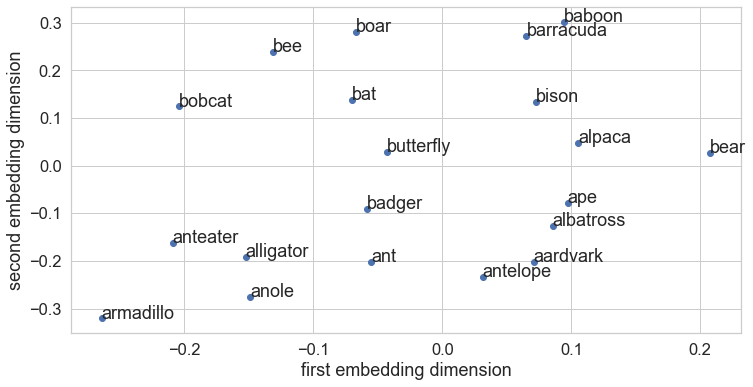

  7%|▋         | 1/15 [00:00<00:03,  3.90it/s]

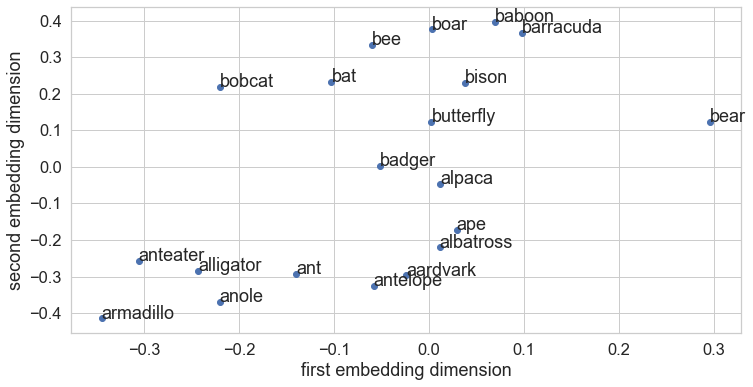

 13%|█▎        | 2/15 [00:00<00:03,  3.83it/s]

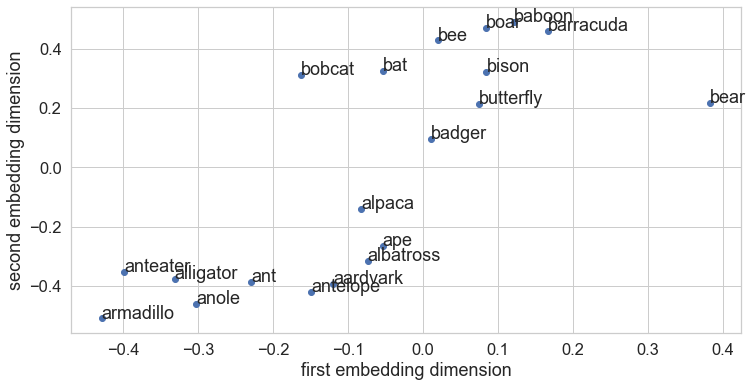

 20%|██        | 3/15 [00:00<00:03,  3.74it/s]

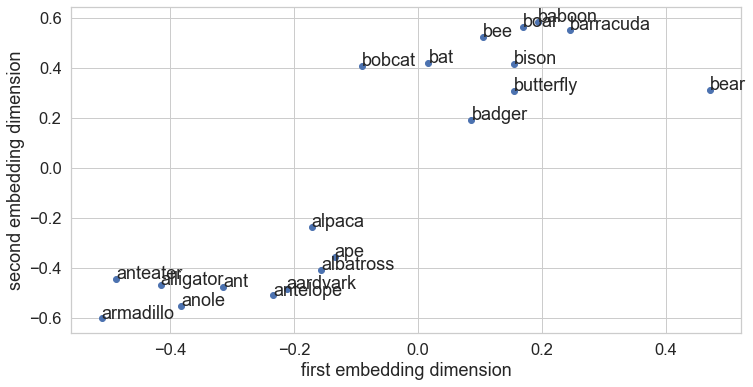

 27%|██▋       | 4/15 [00:01<00:03,  3.66it/s]

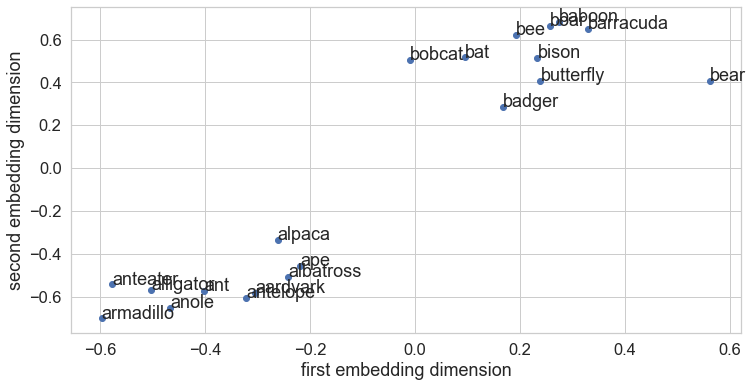

 33%|███▎      | 5/15 [00:01<00:02,  3.60it/s]

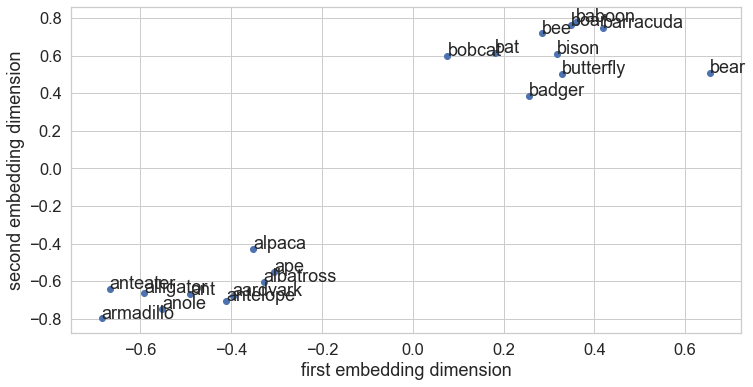

 40%|████      | 6/15 [00:01<00:02,  3.49it/s]

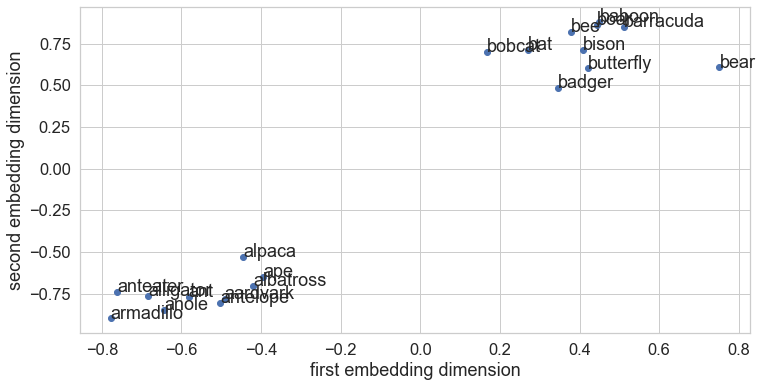

 47%|████▋     | 7/15 [00:02<00:02,  3.33it/s]

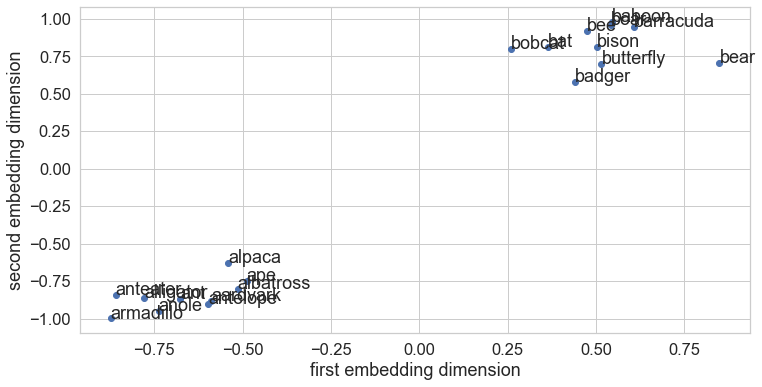

 53%|█████▎    | 8/15 [00:02<00:02,  3.32it/s]

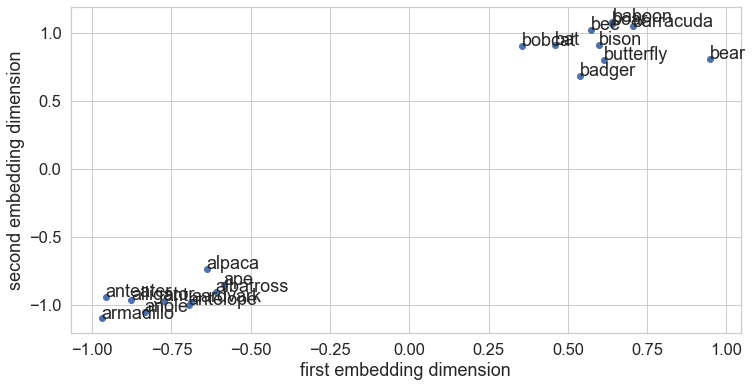

 60%|██████    | 9/15 [00:02<00:01,  3.27it/s]

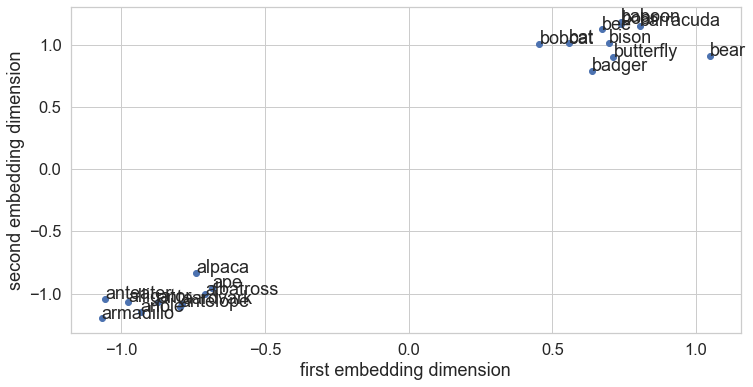

 67%|██████▋   | 10/15 [00:02<00:01,  3.32it/s]

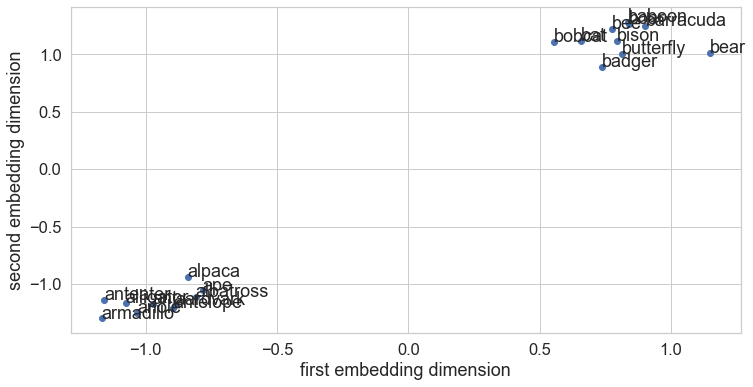

 73%|███████▎  | 11/15 [00:03<00:01,  3.41it/s]

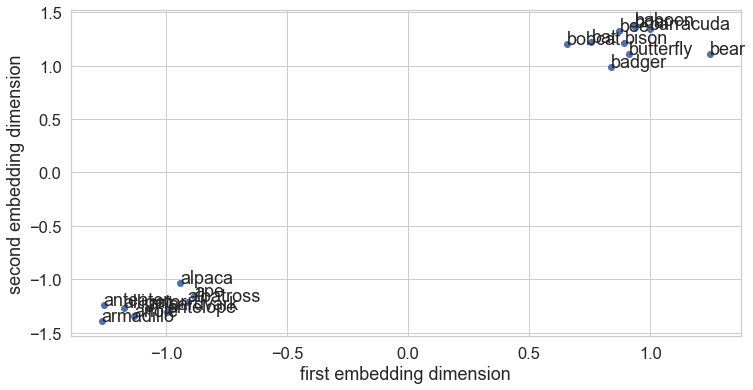

 80%|████████  | 12/15 [00:03<00:00,  3.41it/s]

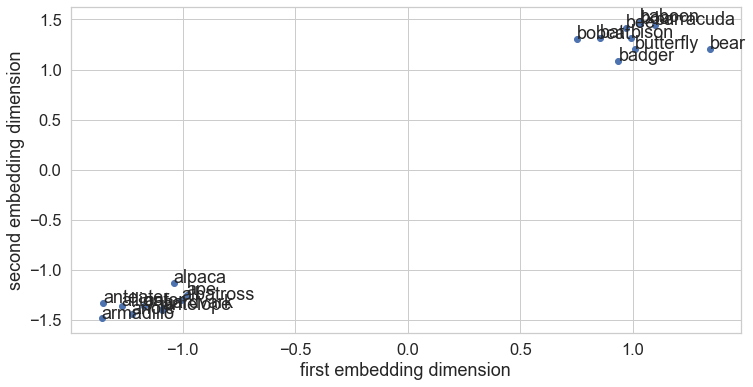

 87%|████████▋ | 13/15 [00:03<00:00,  3.47it/s]

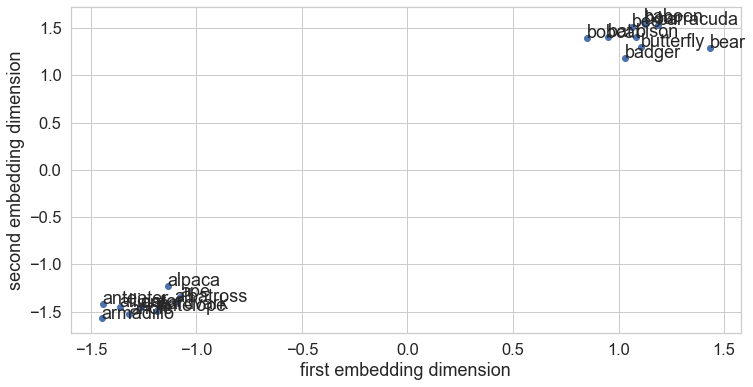

 93%|█████████▎| 14/15 [00:04<00:00,  3.54it/s]

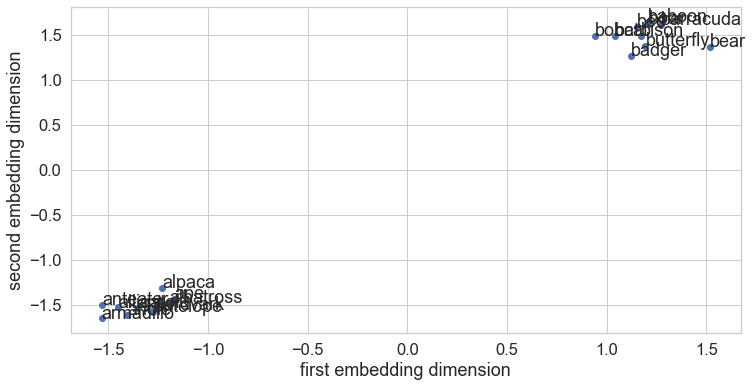

100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


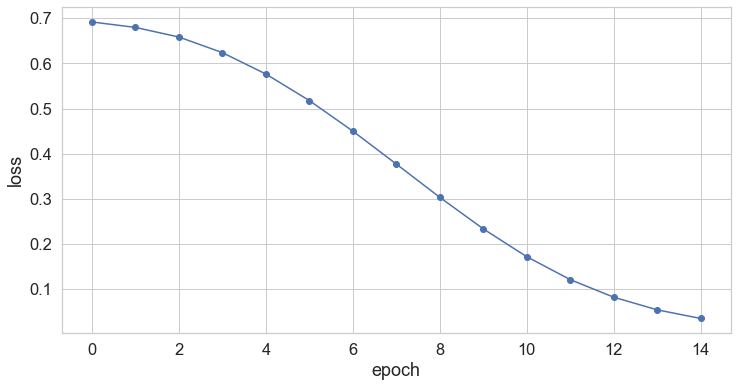

In [640]:
def train_word2vec(data, vocab):
    torch.random.manual_seed(42)
    learning_rate = 0.1
    model = Word2Vec(len(vocab), embedding_size=2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    model.verbose = False

    loss_val = []
    num_epochs=15
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        optimizer.zero_grad() # reset all the gradient information
        words1, words2, labels = make_word2vec_batch(data, vocab)
        outputs = model(words1, words2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_val.append(loss.item())
        animal_embeddings = [word2vec_embedding(animal, model, animal_vocab) for animal in animals]
        plot_embeddings(animal_embeddings, animals)

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

w2v = train_word2vec(animal_data2, animal_vocab)

In [637]:
def word2vec_embedding(word, model, vocabulary):
    return model.input_embedding(vectorize_torch(word, vocabulary)).detach().cpu().numpy()[0]

word2vec_embedding('ant', w2v, animal_vocab)

array([-0.8733239, -1.0717607], dtype=float32)

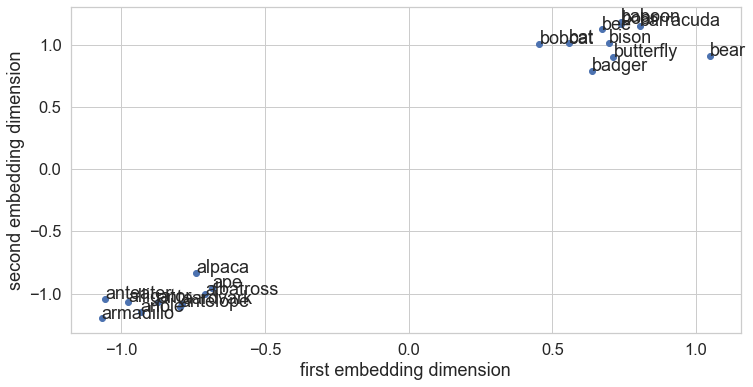

In [638]:
animal_embeddings = [word2vec_embedding(animal, w2v, animal_vocab) for animal in animals]
plot_embeddings(animal_embeddings, animals)

In [357]:
import torch.nn as nn
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size=50, hidden_size=10):
        """
        Params:
          vocab_size.......number of unique words in input
          embedding_size...number of values to represent each word
          hidden_size......number of values in final layer before classification
        """
        super(LanguageModel, self).__init__()
        self.input_to_embedding = nn.Linear(vocab_size, embedding_size)
        self.embedding_to_hidden = nn.Linear(embedding_size * 2, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, 2)
        self.softmax = nn.LogSoftmax(dim=1)
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, word1, word2):
        embedding1 = self.input_to_embedding(word1)
        embedding2 = self.input_to_embedding(word2)
        output = torch.cat((embedding1, embedding2), 1)
        output = self.embedding_to_hidden(output)
        output = self.hidden_to_output(output)
        return self.softmax(output)
   


display(training_words.head(1))
v1, v2 = vectorize_torch('steven', vocabulary), vectorize_torch('sequence', vocabulary)

,w1,w2,label
60111,hardly,contrast,-1


In [365]:
model = LanguageModel(vocab_size=len(vocabulary), embedding_size=50, hidden_size=10)
model(v1, v2)

tensor([[-0.5730, -0.8298]], grad_fn=<LogSoftmaxBackward>)

In [237]:
def label_from_output(output):
    # 0 if false is most probable prediction, 1 if true
    top_n, top_i = output.topk(1)
    return top_i[0].item()

label_from_output(model(v1, v2))

0

In [350]:
def vectorize_batch_torch(batch, vocabulary):
    X = []
    y = []
    for ri, row in batch.iterrows():
        X.append(torch.cat((vectorize_torch(row.w1, vocabulary), vectorize_torch(row.w2, vocabulary)), 1))
        y.append(torch.tensor([1]) if row['label'] == 1 else torch.tensor([0]))  # convert from -1/1 to 0/1
    return X, y
vectorize_batch_torch(training_words.head(10), vocabulary)[0][0].shape

torch.Size([1, 5036])

In [356]:
nn.functional.one_hot(torch.tensor(10), len(vocabulary))

tensor([0, 0, 0,  ..., 0, 0, 0])

In [239]:
vectorize_torch('plot', vocabulary)

tensor([[1., 0., 0.,  ..., 0., 0., 0.]])

In [312]:
torch.random.manual_seed(42)
    
# perform gradient descent for one batch of examples.
def train_on_batch(X_tensors, y_tensors, model, criterion, learning_rate=0.005):
    model.zero_grad()
    loss_sum = 0
    for (x,y) in zip(X_tensors, y_tensors):
        # predict
        output = model(x[0], x[1])
        # compute loss
        loss = criterion(output, y)
        loss_sum += loss.item()
        # print(loss.item())
        # accumulate gradient using back propagation
        loss.backward()        
#     print('loss sum=%.3f' % loss_sum)
    # update parameters in direction of gradient    
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return loss_sum


torch.random.manual_seed(42)
model = LanguageModel(vocab_size=len(vocabulary), embedding_size=50, hidden_size=10)
X_tensors, y_tensors = vectorize_batch_torch(training_words.iloc[::1000], vocabulary)
# loss function: Use negative log likelihood (appropriate since output is Log probabity)
criterion = nn.NLLLoss()
learning_rate = 0.1
train_on_batch(X_tensors, y_tensors, model, criterion)

70.84490138292313

In [314]:
def score(model, X, y):
    from sklearn.metrics import classification_report
    preds = []
    truths = []
    for (x,y) in zip(X, y):
        # predict
        output = model(x[0], x[1])
        pred = label_from_output(output)
        preds.append(pred)
        truths.append(y.item())
    print(classification_report(truths, preds, zero_division=0))
    
score(model, X_tensors, y_tensors)

              precision    recall  f1-score   support

           0       0.48      1.00      0.64        48
           1       0.00      0.00      0.00        53

    accuracy                           0.48       101
   macro avg       0.24      0.50      0.32       101
weighted avg       0.23      0.48      0.31       101



In [318]:
model = LanguageModel(vocab_size=len(vocabulary), embedding_size=50, hidden_size=10)
for _ in range(20):
    train_on_batch(X_tensors, y_tensors, model, criterion, learning_rate=.005)
    score(model, X_tensors, y_tensors)

              precision    recall  f1-score   support

           0       0.48      1.00      0.64        48
           1       0.00      0.00      0.00        53

    accuracy                           0.48       101
   macro avg       0.24      0.50      0.32       101
weighted avg       0.23      0.48      0.31       101

              precision    recall  f1-score   support

           0       0.48      1.00      0.64        48
           1       0.00      0.00      0.00        53

    accuracy                           0.48       101
   macro avg       0.24      0.50      0.32       101
weighted avg       0.23      0.48      0.31       101

              precision    recall  f1-score   support

           0       0.48      1.00      0.64        48
           1       0.00      0.00      0.00        53

    accuracy                           0.48       101
   macro avg       0.24      0.50      0.32       101
weighted avg       0.23      0.48      0.31       101

              preci

In [323]:
def train_language_model(model, training_words, vocabulary, batch_size=100, n_epochs=10):
    criterion = nn.NLLLoss()
    learning_rate = 0.01
    # shuffle rows
    training_words = training_words.sample(frac=1, random_state=42)
    # reserve first 500 rows for unseen testing (e.g., accuracy on held-out data)
    X_test, y_test = vectorize_batch_torch(training_words.iloc[:500], vocabulary)    
    # use last 500 rows for in-sample testing (e.g., accuracy on training data)
    X_train, y_train = vectorize_batch_torch(training_words.iloc[-500:], vocabulary)    
    training_words = training_words.iloc[500:]

    for epoch in range(n_epochs):
        print('epoch %d' % epoch)
        # split into batches, to save memory.
#         for batch in tqdm(np.array_split(training_words, len(training_words)//batch_size)):
        for _, batch in tqdm(training_words.groupby('w1')):
            X, y = vectorize_batch_torch(batch, vocabulary)
            train_on_batch(X, y, model, criterion, learning_rate=0.0001)
        print('train accuracy')
        score(model, X_train, y_train)
        print('test accuracy')
        score(model, X_test, y_test)
    return model

torch.random.manual_seed(42)
model = LanguageModel(vocab_size=len(vocabulary), embedding_size=30, hidden_size=10)
model = train_language_model(model, training_words, vocabulary, batch_size=1000, n_epochs=50)

  0%|          | 3/2518 [00:00<01:35, 26.34it/s]

epoch 0


100%|██████████| 2518/2518 [01:13<00:00, 34.46it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.53      0.42      0.47       242
           1       0.54      0.64      0.59       258

    accuracy                           0.54       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.53      0.54      0.53       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.55       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 1


100%|██████████| 2518/2518 [01:11<00:00, 35.13it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.53      0.43      0.47       242
           1       0.54      0.64      0.59       258

    accuracy                           0.54       500
   macro avg       0.54      0.53      0.53       500
weighted avg       0.54      0.54      0.53       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.55       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 2


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.53      0.43      0.47       242
           1       0.55      0.64      0.59       258

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.53       500
weighted avg       0.54      0.54      0.53       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.40      0.46       257
           1       0.50      0.63      0.56       243

    accuracy                           0.51       500
   macro avg       0.52      0.52      0.51       500
weighted avg       0.52      0.51      0.51       500

epoch 3


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.53      0.43      0.47       242
           1       0.55      0.64      0.59       258

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.53       500
weighted avg       0.54      0.54      0.53       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.56       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 4


100%|██████████| 2518/2518 [01:12<00:00, 34.76it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.53      0.43      0.48       242
           1       0.55      0.65      0.59       258

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.53       500
weighted avg       0.54      0.54      0.54       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.56       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 5


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.53      0.43      0.47       242
           1       0.55      0.65      0.59       258

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.53       500
weighted avg       0.54      0.54      0.53       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.56       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 6


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.54      0.43      0.48       242
           1       0.55      0.66      0.60       258

    accuracy                           0.55       500
   macro avg       0.55      0.54      0.54       500
weighted avg       0.55      0.55      0.54       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.56       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 7


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.54      0.43      0.48       242
           1       0.55      0.66      0.60       258

    accuracy                           0.55       500
   macro avg       0.55      0.54      0.54       500
weighted avg       0.55      0.55      0.54       500

test accuracy
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       257
           1       0.50      0.63      0.56       243

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.50       500
weighted avg       0.51      0.51      0.50       500

epoch 8


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       242
           1       0.56      0.67      0.61       258

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.55       500
weighted avg       0.55      0.55      0.55       500

test accuracy
              precision    recall  f1-score   support

           0       0.54      0.40      0.46       257
           1       0.50      0.64      0.56       243

    accuracy                           0.51       500
   macro avg       0.52      0.52      0.51       500
weighted avg       0.52      0.51      0.51       500

epoch 9


  0%|          | 0/2518 [00:00<?, ?it/s]

train accuracy
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       242
           1       0.56      0.67      0.61       258

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.55       500
weighted avg       0.55      0.55      0.55       500

test accuracy
              precision    recall  f1-score   support

           0       0.54      0.40      0.46       257
           1       0.50      0.64      0.56       243

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.51       500
weighted avg       0.52      0.52      0.51       500

epoch 10


 64%|██████▍   | 1614/2518 [00:48<00:26, 33.62it/s]


KeyboardInterrupt: 

In [320]:
class LanguageModel2(nn.Module):
    def __init__(self, vocab_size, embedding_size=50):
        """
        Params:
          vocab_size.......number of unique words in input
          embedding_size...number of values to represent each word
        """
        super(LanguageModel2, self).__init__()
        self.input_to_embedding = nn.Linear(vocab_size, embedding_size)
        self.embedding_to_output = nn.Bilinear(embedding_size, embedding_size, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, word1, word2):
        embedding1 = self.input_to_embedding(word1)
        embedding2 = self.input_to_embedding(word2)
#         print(embedding1)
#         print(embedding2)
        output = self.embedding_to_output(embedding1, embedding2)
#         print(output)
        return self.softmax(output)


In [321]:
model2 = LanguageModel2(vocab_size=len(vocabulary), embedding_size=50)
model2(v1, v2)

tensor([[-0.6868, -0.6996]], grad_fn=<LogSoftmaxBackward>)

In [331]:
# each batch has dimension: N x V x 2
# N: number of instances
# V: vocabulary size
# 2: one for each element of the word pair
for _, group in training_words.groupby('w1'):
    X, y = vectorize_batch_torch(group, vocabulary)
    print(X)
    break


[(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0

In [324]:
torch.random.manual_seed(42)
model2 = LanguageModel2(vocab_size=len(vocabulary), embedding_size=30)
model2 = train_language_model(model2, training_words, vocabulary, n_epochs=5)

  0%|          | 3/2518 [00:00<01:37, 25.73it/s]

epoch 0


100%|██████████| 2518/2518 [01:35<00:00, 26.49it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.80      0.02      0.03       242
           1       0.52      1.00      0.68       258

    accuracy                           0.52       500
   macro avg       0.66      0.51      0.36       500
weighted avg       0.66      0.52      0.37       500

test accuracy


  0%|          | 3/2518 [00:00<01:34, 26.51it/s]

              precision    recall  f1-score   support

           0       0.67      0.01      0.02       257
           1       0.49      1.00      0.65       243

    accuracy                           0.49       500
   macro avg       0.58      0.50      0.33       500
weighted avg       0.58      0.49      0.33       500

epoch 1


100%|██████████| 2518/2518 [01:36<00:00, 26.20it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.56      0.14      0.22       242
           1       0.53      0.90      0.66       258

    accuracy                           0.53       500
   macro avg       0.54      0.52      0.44       500
weighted avg       0.54      0.53      0.45       500

test accuracy


  0%|          | 2/2518 [00:00<02:44, 15.31it/s]

              precision    recall  f1-score   support

           0       0.51      0.14      0.22       257
           1       0.49      0.86      0.62       243

    accuracy                           0.49       500
   macro avg       0.50      0.50      0.42       500
weighted avg       0.50      0.49      0.42       500

epoch 2


100%|██████████| 2518/2518 [01:34<00:00, 26.72it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.54      0.13      0.21       242
           1       0.52      0.90      0.66       258

    accuracy                           0.53       500
   macro avg       0.53      0.51      0.44       500
weighted avg       0.53      0.53      0.44       500

test accuracy


  0%|          | 3/2518 [00:00<01:33, 26.81it/s]

              precision    recall  f1-score   support

           0       0.51      0.14      0.22       257
           1       0.48      0.86      0.62       243

    accuracy                           0.49       500
   macro avg       0.50      0.50      0.42       500
weighted avg       0.50      0.49      0.41       500

epoch 3


100%|██████████| 2518/2518 [01:38<00:00, 25.55it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.52      0.12      0.20       242
           1       0.52      0.89      0.66       258

    accuracy                           0.52       500
   macro avg       0.52      0.51      0.43       500
weighted avg       0.52      0.52      0.44       500

test accuracy


  0%|          | 3/2518 [00:00<01:50, 22.81it/s]

              precision    recall  f1-score   support

           0       0.50      0.13      0.21       257
           1       0.48      0.86      0.62       243

    accuracy                           0.49       500
   macro avg       0.49      0.50      0.41       500
weighted avg       0.49      0.49      0.41       500

epoch 4


100%|██████████| 2518/2518 [01:36<00:00, 26.15it/s]


train accuracy
              precision    recall  f1-score   support

           0       0.54      0.12      0.20       242
           1       0.52      0.90      0.66       258

    accuracy                           0.52       500
   macro avg       0.53      0.51      0.43       500
weighted avg       0.53      0.52      0.44       500

test accuracy
              precision    recall  f1-score   support

           0       0.52      0.13      0.21       257
           1       0.49      0.87      0.62       243

    accuracy                           0.49       500
   macro avg       0.50      0.50      0.42       500
weighted avg       0.50      0.49      0.41       500



In [33]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
writer = SummaryWriter('runs/run1')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

Extracting mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_train/MNIST/raw



Extracting mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_train/MNIST/raw
Processing...
Done!



/Users/culotta/Library/Python/3.8/lib/python/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [32]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 35406), started 0:01:25 ago. (Use '!kill 35406' to kill it.)

nn.Module =~ layer of a neural net layer

In [ ]:
from math import sqrt

def cosine(v1, v2):
    return np.dot(v1, v2) / (sqrt(np.dot(v1, v1)) * sqrt(np.dot(v2, v2)))
    
def word_sim(w1, w2, mlp, vocabulary):
    v1 = mlp.coefs_[0][vocabulary[w1]]
    v2 = mlp.coefs_[0][vocabulary[w2]]
    return cosine(v1, v2)
    
word_sim("him", "hate", mlp, vocabulary)
# len(vocabulary)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(mlp.coefs_[0])


In [ ]:
reverse_vocab = {i:w for w,i in vocabulary.items()}

for wi, word in enumerate(vocabulary):
    print('\n\n',word, wi)
    for wj in sims[wi][:len(vocabulary)].argsort()[::-1][1:6]:
        print(reverse_vocab[wj])
    if wi > 100:
        break

In [ ]:
vocabulary['get']